In [8]:
!pip3 install transformers

     |████████████████████████████████| 3.3 MB 11.2 MB/s 
     |████████████████████████████████| 3.3 MB 28.6 MB/s 
     |████████████████████████████████| 61 kB 517 kB/s 
     |████████████████████████████████| 596 kB 39.2 MB/s 
     |████████████████████████████████| 895 kB 39.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [9]:
import pandas as pd
import numpy as np
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import gensim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from transformers import BertTokenizerFast , BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data =pd.read_csv('/content/drive/MyDrive/Newfolder/Code_And_Data/fake-news/train.csv')

In [8]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [9]:
data.fillna('', inplace =True)

In [10]:
X = data['author']+ ' '+ data['title']+ ' ' + data['text']
Y = data['label']

In [11]:
type(X)

pandas.core.series.Series

In [12]:
len(X[0])

5026

#lower case conversion


In [13]:
X = X.str.lower()

#remove stopwords


In [14]:
X= X.apply(lambda x: remove_stopwords(x))

#remove punctuation

In [15]:

X = X.str.replace('[^\w\s]',' ').str.replace(r"http\S+|www\S+|https\S+",' ').str.replace(r'\@\w+|\#', ' ')
X = X.str.replace(r'\b\w\b', ' ').str.replace(r'\s+', ' ')

#Lemmatization

In [16]:
mylemitizer = WordNetLemmatizer()

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
X =  X.apply(lambda sentence: ' '.join([mylemitizer.lemmatize(w) for w in nltk.word_tokenize(sentence)]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.to_list(),Y.to_list(),test_size=0.3)

In [ ]:
mytokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_weights = mytokenizer(X_train, truncation=True, padding=True, max_length=512)



In [ ]:
test_weights = mytokenizer(X_test, truncation=True, padding=True, max_length=512)

In [ ]:
#class for obtaining torch data from tokenized weights
class myTorchData(torch.utils.data.Dataset):
    def __init__(self, weights, labels):
        self.weights = weights
        self.labels = labels

    def __getitem__(self, index):
        item = {i: torch.tensor(j[index]) for i, j in self.weights.items()}
        item["labels"] = torch.tensor([self.labels[index]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
#torch train dataset
train_dataset = myTorchData(train_weights, y_train)

In [ ]:
#torch test dataset
test_dataset = myTorchData(test_weights, y_test)


In [ ]:
#fetching pretrained bert model for our classifictaion task
model=BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to("cuda")

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache 

In [ ]:
#training argunments
training_args = TrainingArguments(output_dir='./mysteps', num_train_epochs=1,per_device_eval_batch_size=20,warmup_steps=300,weight_decay=0.01,load_best_model_at_end=True,logging_steps=300,save_steps=300,evaluation_strategy="steps", )

using `logging_steps` to initialize `eval_steps` to 300
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
def accuracyScore(modelPrediction):
    original = modelPrediction.label_ids
    prediction = modelPrediction.predictions.argmax(-1)
    return {'accuracy': accuracy_score(original, prediction)}


In [ ]:
trainer = Trainer(model=model, args=training_args,train_dataset=train_dataset,eval_dataset=test_dataset,compute_metrics=accuracyScore)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 14560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1820


Step,Training Loss,Validation Loss,Accuracy
300,0.437400,0.139745,0.954487
600,0.138300,0.096293,0.978205
900,0.074300,0.095184,0.982051


***** Running Evaluation *****
  Num examples = 6240
  Batch size = 20
Saving model checkpoint to ./mysteps/checkpoint-300
Configuration saved in ./mysteps/checkpoint-300/config.json
Model weights saved in ./mysteps/checkpoint-300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6240
  Batch size = 20
Saving model checkpoint to ./mysteps/checkpoint-600
Configuration saved in ./mysteps/checkpoint-600/config.json
Model weights saved in ./mysteps/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6240
  Batch size = 20
Saving model checkpoint to ./mysteps/checkpoint-900
Configuration saved in ./mysteps/checkpoint-900/config.json
Model weights saved in ./mysteps/checkpoint-900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6240
  Batch size = 20


Step,Training Loss,Validation Loss,Accuracy
300,0.437400,0.139745,0.954487
600,0.138300,0.096293,0.978205
900,0.074300,0.095184,0.982051
1200,0.066800,0.043043,0.991827
1500,0.054400,0.034180,0.993109


Saving model checkpoint to ./mysteps/checkpoint-1200
Configuration saved in ./mysteps/checkpoint-1200/config.json
Model weights saved in ./mysteps/checkpoint-1200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6240
  Batch size = 20
Saving model checkpoint to ./mysteps/checkpoint-1500
Configuration saved in ./mysteps/checkpoint-1500/config.json
Model weights saved in ./mysteps/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6240
  Batch size = 20


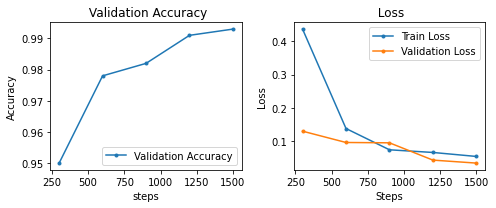

In [10]:
epochs=[300,600,900,1200,1500]
#train_acc=[.869,.967,.981,.989,.993,.995,.996,.997,.997,.998]
train_loss=[0.437,0.138,0.074,0.066,0.054]
val_acc=[0.95,0.978,.982,.991,.993]
val_loss=[0.13,0.096,0.095,.043,.034]

fig , ax = plt.subplots(1,2,figsize=(7,3))
#ax[0].plot(epochs , train_acc , '.-' , label = 'Train Accuracy')
ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
ax[0].set_title(' Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("steps")
ax[0].set_ylabel("Accuracy")
ax[1].plot(epochs , train_loss , '.-' , label = 'Train Loss')
ax[1].plot(epochs , val_loss , '.-' , label = 'Validation Loss')
ax[1].set_title(' Loss')
ax[1].legend()
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
fig.tight_layout()
fig.show()